# Text Classification Using BERT


## Steps to be followed:
1. Import the required libraries for working with Bert and training a Bert-based model
2. Read and previewing data from a CSV file using Pandas
3. Visualize category distribution with a bar chart
4. Customize the dataset class for text classification with BERT tokenization
5. Fine-tune BERT for text classification
6. Train and validation loop for a BERT-based classifier
7. Implement functions for model evaluation
8. Split the dataset
9. Train the model
10. Evaluate the model
11. Perform Cross-Validation
12. Examine Confusion Matrix and Other Metrics

### Step 1: Import the required libraries for working with Bert and training a Bert-based model
- Import pandas for data manipulation.

- Import torch for tensor operations and neural networks.
- Import NumPy for numerical operations.
- Import BertTokenizer and BertModel from the transformers library for BERT-specific functionalities.
- Import nn from torch for neural network components.
- Import Adam from torch.optim for the Adam optimizer.
- Import tqdm for creating progress bars. These imports set up the required dependencies for working with BERT and training a BERT-based model.

In [1]:
import os

# Disable oneDNN optimizations to avoid potential minor numerical differences caused by floating-point round-off errors.
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu125
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu125

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import torchvision
torchvision.disable_beta_transforms_warning()

import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

### Step 2: Read and preview data from a CSV file using Pandas
- Read the CSV file into a DataFrame.
- Display the first few rows of the DataFrame.



In [5]:
#datapath = f'/content/bbc-text.csv'
df = pd.read_csv("bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


**Observation:**

The code reads a CSV file named **bbc-text.csv** from the specified path and displays the first few rows of the dataset.

### Step 3: Visualize category distribution with a bar chart
- Group the DataFrame by category column and calculate the size of each group.
- Plot a bar chart to visualize the group sizes.



<Axes: xlabel='category'>

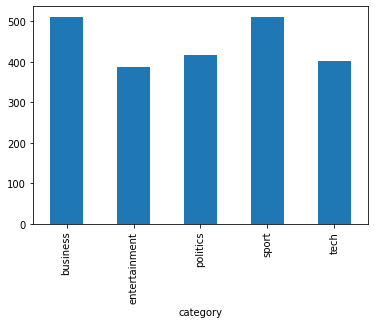

In [6]:
df.groupby(['category']).size().plot.bar()

**Observation:**

The code snippet performs a groupby operation on the category column of the DataFrame df, calculates the size of each category group, and then creates a bar plot to visualize the distribution of categories.

### Step 4: Customize dataset class for text classification with BERT tokenization
- Initialize the tokenizer from the BERT model.
- Define a dictionary to map category labels to numerical values.
- Define a custom dataset class for text classification.
- Map category labels to numerical values.
- Tokenize and encode texts using the tokenizer.
- Return the labels of the dataset.
- Return the length of the dataset.
- Fetch a batch of labels given an index.
- Fetch a batch of tokenized texts given an index.
- Retrieve a batch of tokenized texts and labels.


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {val: idx for idx, val in enumerate(sorted(df["category"].unique()))}


class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, padding='max_length', max_length=512, truncation=True, return_tensors="pt")
                      for text in df['text']]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = torch.tensor(self.labels[idx])
        text = self.texts[idx]
        return text, label

**Observation:**

This code initializes a BERT tokenizer and defines a custom dataset class for text classification. The class maps categories to numerical labels, tokenizes and encodes texts, and provides methods to retrieve batches of tokenized texts and labels. This setup is essential for preparing the data for model training.

### Step 5: Fine-tune BERT for text classification
- Define a PyTorch module for text classification using BERT as the base model.
- Load the pre-trained BERT model.
- Define a dropout layer with the specified dropout rate.
- Define a linear layer with an input size of 768 and an output size of 5.
- Define a ReLU activation function.
- Perform a forward pass through the BERT model.
- Apply dropout to the pooled output.
- Pass the dropout output through the linear layer.
- Apply the ReLU activation function to the linear output



In [8]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_output = self.relu(linear_output)
        return final_output


**Observation:**

This code defines a PyTorch module for text classification using BERT as the base model. It loads a pre-trained BERT model, defines a dropout layer, a linear layer, and a ReLU activation function. The forward method performs a forward pass through the BERT model, applies dropout, passes the output through the linear layer, and applies ReLU activation. This setup fine-tunes BERT for the classification task.

### Step 6: Train and validate loop for a BERT-based classifier
- Create dataset objects and data loaders for training and validation data.
- Check if CUDA is available and set the device accordingly.
- Define the loss function and optimizer.
- Move the model and loss function to CUDA if available.
- The training loop iterates over the batches of training data. It moves the inputs and labels to the device, performs the forward pass through the model, calculates the batch loss and accuracy, performs the backward pass and optimization step, and updates the total loss and accuracy.

- Similarly, the validation loop iterates over the batches of validation data. It performs the forward pass, calculates the batch loss and accuracy, and updates the total loss and accuracy.
- Print epoch results.


In [9]:
# Initialize the device:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cuda


In [10]:
def train(model, train_data, val_data, learning_rate, epochs, device):
    train_dataset = Dataset(train_data)
    val_dataset = Dataset(val_data)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch in range(epochs):
        model.train()
        total_loss_train = 0
        total_acc_train = 0

        for train_input, train_label in tqdm(train_loader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].squeeze(1).to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()
            output = model(input_id, mask)

            loss = criterion(output, train_label)
            total_loss_train += loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            loss.backward()
            optimizer.step()

        model.eval()
        total_loss_val = 0
        total_acc_val = 0

        with torch.no_grad():
            for val_input, val_label in val_loader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].squeeze(1).to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                loss = criterion(output, val_label)
                total_loss_val += loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        print(f'Epochs: {epoch + 1} | Train Loss: {total_loss_train / len(train_loader): .3f} | '
              f'Train Accuracy: {total_acc_train / len(train_loader.dataset): .3f} | '
              f'Val Loss: {total_loss_val / len(val_loader): .3f} | '
              f'Val Accuracy: {total_acc_val / len(val_loader.dataset): .3f}')


**Observation:**

This code implements the training and validation loops for a BERT-based classifier. It creates dataset objects and data loaders for training and validation data, checks for CUDA availability, and sets the device accordingly. It defines the loss function and optimizer, moves the model and loss function to CUDA if available, and iterates over batches of data to perform training and validation. The training loop calculates batch loss and accuracy, performs the backward pass and optimization step, and updates total loss and accuracy. The validation loop performs similar steps without gradient calculation. Epoch results are printed at the end of each epoch.

### Step 7: Implement functions for model evaluation
- Evaluate the performance of a trained model on the provided test data.
- Create a dataset object using the test data.
- Create a DataLoader to iterate over the test dataset in batches.
- Check if a GPU is available.
- Set the device to CUDA if available; otherwise, use CPU.
- Move the model to the GPU if available.
- Initialize a variable to keep track of the total accuracy of the test data.
- Disable gradient calculation for evaluation.
- For each batch, the input tensors are moved to the device (GPU, if available), and the model is used to generate predictions. The accuracy is computed by comparing the predicted labels with the true labels, and the count of correct predictions is accumulated in total_acc_test.
- Print the test accuracy by dividing total_acc_test by the length of the test data.

In [11]:
def evaluate(model, test_data, device):
    test_dataset = Dataset(test_data)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():
        model.eval()
        for test_input, test_label in test_loader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].squeeze(1).to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_loader.dataset): .3f}')

**Observation:**

This code evaluates the performance of a trained model on the provided test data. It creates a dataset object using the test data, a DataLoader to iterate over the test dataset in batches, checks if a GPU is available, sets the device to CUDA if available, and moves the model to the GPU if available. It initializes a variable to keep track of the total accuracy of the test data, disables gradient calculation for evaluation, and iterates over batches to generate predictions and compute accuracy. The test accuracy is printed at the end.

### Step 8: Split the dataset
- Split the DataFrame into train, validation, and test sets using random sampling.
- Print the lengths of the train, validation, and test sets.


In [12]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train), len(df_val), len(df_test))


1780 222 223


/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


**Observation:**

This code splits the DataFrame into train, validation, and test sets using random sampling. It ensures reproducibility by setting a random seed and splits the DataFrame into three subsets based on specified proportions. The lengths of the train, validation, and test sets are printed to verify the splits.

### Step 9: Train the model
- The number of epochs to train the model is 5.
- Create an instance of the BertClassifier model.
- **1e-6** is the learning rate for the optimizer.
- Call the train function to train the model.


In [13]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS, device)

100%|██████████| 112/112 [02:36<00:00,  1.40s/it]


Epochs: 1 | Train Loss:  1.629 | Train Accuracy:  0.244 | Val Loss:  1.486 | Val Accuracy:  0.450


100%|██████████| 112/112 [02:30<00:00,  1.34s/it]


Epochs: 2 | Train Loss:  1.489 | Train Accuracy:  0.390 | Val Loss:  1.291 | Val Accuracy:  0.748


100%|██████████| 112/112 [02:30<00:00,  1.34s/it]


Epochs: 3 | Train Loss:  1.265 | Train Accuracy:  0.601 | Val Loss:  1.033 | Val Accuracy:  0.784


100%|██████████| 112/112 [02:30<00:00,  1.34s/it]


Epochs: 4 | Train Loss:  1.028 | Train Accuracy:  0.740 | Val Loss:  0.735 | Val Accuracy:  0.941


100%|██████████| 112/112 [02:30<00:00,  1.34s/it]


Epochs: 5 | Train Loss:  0.750 | Train Accuracy:  0.899 | Val Loss:  0.516 | Val Accuracy:  0.973


**Observation:**

The code trains a BERT-based classifier model for 5 epochs using a learning rate of 1e-6 on the training and validation datasets.

### Step 10: Evaluate the model

In [14]:
evaluate(model, df_test, device)

Test Accuracy:  0.987


**Observation**:

The code evaluates the performance of the trained BERT-based classifier model on the test dataset df_test.

### Step 11: Perform Cross-Validation

- Perform 3-fold cross-validation to ensure the model's - - - performance is consistent across different subsets of the data.
- Use KFold from sklearn.model_selection for splitting the dataset.
- Define batch size and epochs for the training process.
For each fold:
- Split the dataset into training and validation sets.
- Create DataLoader objects for both sets.
- Initialize the BertClassifier model, loss function, and optimizer.
- Train the model on the training set.
- Evaluate the model on the validation set.
- Store the accuracy of each fold.
- Print the training loss for each fold.
- Print the validation accuracy for each fold.
- Calculate and print the mean accuracy across all folds.

In [15]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)
accuracies = []

BATCH_SIZE = 16
EPOCHS = 1

for fold, (train_index, val_index) in enumerate(kf.split(df)):
    print(f"Fold {fold + 1}")
    df_train, df_val = df.iloc[train_index][:100], df.iloc[val_index][:50]
    train_dataset = Dataset(df_train)
    val_dataset = Dataset(df_val)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = BertClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-6)

    model.train()
    total_loss_train = 0
    for batch_idx, (train_input, train_label) in enumerate(train_loader):
        train_label = train_label.to(device)
        mask = train_input['attention_mask'].squeeze(1).to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)

        optimizer.zero_grad()
        output = model(input_id, mask)
        loss = criterion(output, train_label)
        total_loss_train += loss.item()
        loss.backward()
        optimizer.step()

    print(f"Fold {fold + 1}, Training Loss: {total_loss_train / len(train_loader):.4f}")

    model.eval()
    val_acc = 0
    with torch.no_grad():
        for val_input, val_label in val_loader:
            val_label = val_label.to(device)
            mask = val_input['attention_mask'].squeeze(1).to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            val_acc += (output.argmax(dim=1) == val_label).sum().item()

    accuracies.append(val_acc / len(val_dataset))
    print(f"Fold {fold + 1}, Validation Accuracy: {val_acc / len(val_dataset):.4f}")

print(f"Cross-Validation Accuracies: {accuracies}")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")

Fold 1
Fold 1, Training Loss: 1.6874
Fold 1, Validation Accuracy: 0.1400
Fold 2
Fold 2, Training Loss: 1.6637
Fold 2, Validation Accuracy: 0.2600
Fold 3
Fold 3, Training Loss: 1.6722
Fold 3, Validation Accuracy: 0.1600
Cross-Validation Accuracies: [0.14, 0.26, 0.16]
Mean Accuracy: 0.1867


**Observation:**

This simplified code performs 3-fold cross-validation to ensure the model's high accuracy is consistent across different subsets of the data. The training process is expedited by reducing the number of epochs to 1 and increasing the batch size to 16. Additionally, a smaller subset of data is used for quick validation. The mean accuracy across all folds is printed to provide a robust estimate of model performance. The mean accuracy is low because of the small size of the subset of data passed to it.

### Step 12: Examine Confusion Matrix and Other Metrics

- Define a function to get predictions and true labels from the model.
- Use the DataLoader to iterate over the test dataset.
- Collect predictions and true labels for each batch.
- Calculate and print the classification report, which includes precision, recall, and F1-score for each class.
- Compute and display the confusion matrix using a heatmap to visualize the model's performance across different classes.

               precision    recall  f1-score   support

     business       1.00      0.00      0.00        57
entertainment       1.00      0.00      0.00        33
     politics       1.00      0.00      0.00        43
        sport       1.00      0.00      0.00        50
         tech       0.18      1.00      0.30        40

     accuracy                           0.18       223
    macro avg       0.84      0.20      0.06       223
 weighted avg       0.85      0.18      0.05       223



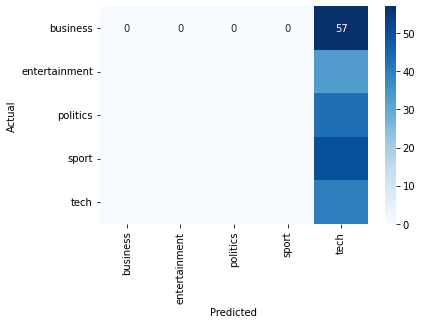

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to get predictions and true labels
def get_predictions(model, data_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for input_data, labels in data_loader:
            input_id = input_data['input_ids'].squeeze(1).to(device)
            mask = input_data['attention_mask'].squeeze(1).to(device)
            output = model(input_id, mask)
            preds = output.argmax(dim=1).cpu().numpy()
            labels = labels.cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels)
    return predictions, true_labels

test_loader = torch.utils.data.DataLoader(Dataset(df_test), batch_size=2)
predictions, true_labels = get_predictions(model, test_loader)

print(classification_report(true_labels, predictions, target_names=labels.keys(), zero_division=1))

cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


**Observation:**

This code calculates and displays additional evaluation metrics, including the classification report and confusion matrix. These metrics provide a detailed understanding of the model's performance across different classes, ensuring the high accuracy is not due to class imbalance.